In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy
import logging
import mne 
import re

from Function import *
from extract_numbers import *

In [2]:
# =============================================================================
# Configuration: Paths and Parameters
# =============================================================================
# Set up logging: messages will include timestamp, log level, and message content
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

PREPROCESSED_DATA_ROOT_MEM = '../data/preprocessData/Memory'
PREPROCESSED_DATA_ROOT_PERC = '../data/preprocessData/Perception'

RESULTS_MEM = '../results/Memory'
RESULTS_PERC = '../results/Perception'

BIDS_TASK_LABEL_MEM = '_task-memoryBasedDecisionMaking'
BIDS_TASK_LABEL_PERC = '_task-perceptionBasedDecisionMaking'
BIDS_BEH_SUFFIX = '_beh'
BIDS_EEG_SUFFIX = '_eeg'

SAMPLING_RATE = 500
CHANNEL_INDICES = [26, 27, 28]

T_ERP_START, T_ERP_END = -1.0, 0.1
T_BASELINE_START, T_BASELINE_END = -1.0, -0.8
T_AMS_SLPS_START, T_AMS_SLPS_END = -0.18, -0.08
T_PAMS_START, T_PAMS_END = -0.05, 0.05

SUBJECT_DIR = [f'ACC{i:03}' for i in range(14, 37)]  # ACC014 to ACC036

In [3]:
# ==============================
# Helper Functions
# ==============================

def load_behavior_data(sub_id, task_mode):
    if task_mode == 'mem':
        path = PREPROCESSED_DATA_ROOT_MEM
        BIDS_TASK_LABEL = BIDS_TASK_LABEL_MEM
    else:
        path = PREPROCESSED_DATA_ROOT_PERC
        BIDS_TASK_LABEL = BIDS_TASK_LABEL_PERC
    
    # Set path for behavior
    path_behavior = os.path.join(path,
                                 'sub-'+sub_id,
                                 'beh',
                                 'sub-'+sub_id+BIDS_TASK_LABEL+BIDS_BEH_SUFFIX+'.tsv')
    assert os.path.exists(path_behavior), f"{sub_id} : behavior file not found: {path_behavior}"
    
    # Load behavior data
    data_behavior = pd.read_csv(path_behavior, sep='\t', header=0)
    data_behavior['subj_idx'] = sub_id

    return data_behavior

def calculate_condition(data_behavior, task_mode):
    # Set mapping rules
    if task_mode == 'mem':
        mapping = {1: -3, 2: 0, 3: 3}
    elif task_mode == 'perc':
        mapping = {1: -2, 2: 0, 3: 2}

    # Extract number of each item
    def extract_numbers(str):
        if pd.isna(str):
            return []
        return [float(x) for x in re.findall(r'\d+', str)]

    data_behavior['item_1_number'] = data_behavior['item_1'].apply(extract_numbers)
    data_behavior['item_2_number'] = data_behavior['item_2'].apply(extract_numbers)
    data_behavior['item_cue_number'] = data_behavior['item_cue'].apply(extract_numbers)

    # Employ mapping for each item
    def map_to_pca(num_list):
        if len(num_list) == 0:
            return []
        return [mapping[int(x)] for x in num_list]
    
    data_behavior['item_1_number'] = data_behavior['item_1_number'].apply(map_to_pca)
    data_behavior['item_2_number'] = data_behavior['item_2_number'].apply(map_to_pca)
    data_behavior['item_cue_number'] = data_behavior['item_cue_number'].apply(map_to_pca)
    
    # Different conditions have different algorithm to get values
    if task_mode == 'mem':
        # Define a function to acquire the type of trials (match or non-matc)
        def is_match_mem(row):
            cue = np.array(row['item_cue_number'])
            item_1 = np.array(row['item_1_number'])
            item_2 = np.array(row['item_2_number'])
            return np.array_equal(cue, item_1) or np.array_equal(cue, item_2)
        
        data_behavior['trial_type'] = data_behavior.apply(is_match_mem, axis=1).map({True: 'match', False: 'non-match'})

        # Compute summed_similarity for ALL trials
        summed_similarities = []
        for _, row in data_behavior.iterrows():
            cue = np.array(row['item_cue_number'])
            item_1 = np.array(row['item_1_number'])
            item_2 = np.array(row['item_2_number'])
            distance_1 = np.linalg.norm(cue - item_1)
            distance_2 = np.linalg.norm(cue - item_2)
            max_distance = np.sqrt(108.0)  # sqrt(3 * 6^2)
            sim1 = 1 - distance_1 / max_distance
            sim2 = 1 - distance_2 / max_distance
            summed_similarities.append(sim1 + sim2)
        data_behavior['summed_similarity'] = summed_similarities

        # Binning: only on non-match trials
        data_behavior['similarity_bin'] = pd.NA
        non_match_mask = data_behavior['trial_type'] == 'non-match'
        vals = data_behavior.loc[non_match_mask, 'summed_similarity'] 
        bins = pd.qcut(vals, q=4, labels=[1, 2, 3, 4], duplicates='drop')
        data_behavior.loc[non_match_mask, 'similarity_bin'] = bins.astype('Int64')

    elif task_mode == 'perc':
        # Define a function to acquire the type of trials (match or non-matc)
        def is_match_perc(row):
            item_1 = np.array(row['item_1_number'])
            item_2 = np.array(row['item_2_number'])
            return np.array_equal(item_1, item_2)
        
        data_behavior['trial_type'] = data_behavior.apply(is_match_perc, axis=1).map({True: 'match', False: 'non-match'})
        
        # Compute summed_similarity for ALL trials
        similarities = []
        for _, row in data_behavior.iterrows():
            item_1 = np.array(row['item_1_number'])
            item_2 = np.array(row['item_2_number'])
            distance = np.linalg.norm(item_1 - item_2)
            max_distance = np.sqrt(48.0)  # sqrt(3 * 4^2)
            sim = 1 - distance / max_distance
            similarities.append(sim)
        data_behavior['similarity'] = similarities

        # Binning: only on non-match trials
        data_behavior['similarity_bin'] = pd.NA
        non_match_mask = data_behavior['trial_type'] == 'non-match'
        vals = data_behavior.loc[non_match_mask, 'similarity'] 
        bins = pd.qcut(vals, q=4, labels=[1, 2, 3, 4], duplicates='drop')
        data_behavior.loc[non_match_mask, 'similarity_bin'] = bins.astype('Int64')
    
    return data_behavior

def load_eeg_data(sub_id, task_mode):
    if task_mode == 'mem':
        path = PREPROCESSED_DATA_ROOT_MEM
        BIDS_TASK_LABEL = BIDS_TASK_LABEL_MEM
    else:
        path = PREPROCESSED_DATA_ROOT_PERC
        BIDS_TASK_LABEL = BIDS_TASK_LABEL_PERC
    path_eeg = os.path.join(path,
                            'sub-'+sub_id,
                            'eeg',
                            'sub-'+sub_id+BIDS_TASK_LABEL+BIDS_EEG_SUFFIX+'.vhdr')
    assert os.path.exists(path_eeg), f"{sub_id} : eeg file not found: {path_eeg}"

    # Load eeg data
    eeg_bids = mne.io.read_raw_brainvision(path_eeg, preload=False)
    events, event_id = mne.events_from_annotations(eeg_bids)

    return eeg_bids, events, event_id

def remove_rt_outlier(data_behavior, events, event_id, events_id_response, RT_OUTLIER_STD_MULTIPLIER=3):

    # Calculate the boundary of rt
    rt_mean = np.nanmean(data_behavior['rt'])
    rt_std = np.nanstd(data_behavior['rt'])
    rt_lower = rt_mean - RT_OUTLIER_STD_MULTIPLIER * rt_std
    rt_upper = rt_mean + RT_OUTLIER_STD_MULTIPLIER * rt_std

    mask_data_behavior_clean = (
        (data_behavior['rt'] >= rt_lower) &
        (data_behavior['rt'] <= rt_upper)
    )

    index_data_behavior_clean = np.where(mask_data_behavior_clean)[0]

    # Remove outlier trials
    data_behavior_clean = data_behavior.iloc[index_data_behavior_clean].reset_index(drop=True)

    # Remove outlier events
    event_id_key_response = {events_id_response: event_id[events_id_response]}
    events_response = events[events[:, 2] == event_id_key_response[events_id_response]]
    events_clean = events_response[index_data_behavior_clean]

    n_data_behavior_clean = len(data_behavior_clean)
    n_events_clean = len(events_clean)
    # Confirm that the number of response events matches the number of behavioral trials
    assert n_events_clean == n_data_behavior_clean, f"Trial count mismatch! EEG: {n_events_clean}, Behavior: {n_data_behavior_clean}"

    return data_behavior_clean, events_clean, event_id_key_response


def epoch_save_CPP(sub_id, eeg_bids, events_clean, event_id_key_response, task_mode):
    # Set path to save CPP and joint modeling
    if task_mode == 'mem':
        path_results = RESULTS_MEM
    else:
        path_results = RESULTS_PERC
    path_results_cpp = os.path.join(path_results, 'cpp')
    os.makedirs(path_results_cpp, exist_ok=True)

    # Epoch full eeg data
    data_eeg_epochs = mne.Epochs(
        raw = eeg_bids, 
        events = events_clean, 
        event_id = event_id_key_response,
        tmin = T_ERP_START, tmax = T_ERP_END,
        baseline = (T_BASELINE_START, T_BASELINE_END), 
        preload=True
    )

    # Select 3 certain channels for erp and averge channels and trials for CPP
    data_erp = data_eeg_epochs.get_data(picks=CHANNEL_INDICES)
    data_cpp = np.nanmean(data_erp, axis=(0, 1))

    # save CPP data into .mat files
    scipy.io.savemat(os.path.join(path_results_cpp, f'cpp_{sub_id}.mat'), {'CPP': data_cpp})

    return data_cpp

def process_pipeline_cpp(eeg_bids, events_clean, event_id_key_response):
    
    # AMS & SLPS window
    data_eeg_epochs_ams_slps = mne.Epochs(
        raw = eeg_bids, 
        events = events_clean, 
        event_id = event_id_key_response,
        tmin=T_AMS_SLPS_START, tmax=T_AMS_SLPS_END,
        baseline = None, 
        preload=True
    )
    data_ams_slps = data_eeg_epochs_ams_slps.get_data(picks=CHANNEL_INDICES)
    data_ams_slps_average = np.nanmean(data_ams_slps, axis=1)   # (n_trials, n_times)

    # PAMS window
    eeg_epochs_pams = mne.Epochs(
        raw = eeg_bids, 
        events = events_clean, 
        event_id = event_id_key_response,
        tmin=T_PAMS_START, tmax=T_PAMS_END,
        baseline = None,
        preload = True
    )
    data_pams = eeg_epochs_pams.get_data(picks=CHANNEL_INDICES)
    data_pams_average = np.nanmean(data_pams, axis=1)   # (n_trials, n_times)

    # Calculate each features 
    ams = np.nanmean(data_ams_slps_average, axis=1)
    pams = np.nanmax(data_pams_average, axis=1)

    # SLPS: smoothing and slope
    data_slps = pd.DataFrame(data_ams_slps_average)
    data_slps_smooth = smooth(data_slps, sample_rate=SAMPLING_RATE)

    n_trials = data_ams_slps_average.shape[0]
    slps = np.empty(n_trials)
    time_vector = np.arange(data_slps_smooth.shape[1]) / SAMPLING_RATE
    for i in range(n_trials):
        y = data_slps_smooth.iloc[i, :]
        slope = np.polyfit(time_vector, y, deg=1)[0]        
        slps[i] = slope
            
    # Validation: no all-NaN features
    assert not np.all(np.isnan(ams)), "All AMS values are NaN"
    assert not np.all(np.isnan(pams)), "All PAMS values are NaN"
    assert not np.all(np.isnan(slps)), "All SLPS values are NaN"

    data_features = pd.DataFrame({
        'ams': ams,
        'pams': pams,
        'slps': slps
    })

    # Calculate features in bin
    # Quantile binning based on ORIGINAL values 
    for feature in ['ams', 'pams', 'slps']:
        quantile_col = f"{feature}_quantile"

        def safe_qcut_original(x):
            # x is the ORIGINAL feature values
            x_clean = x.dropna()
            if x_clean.nunique() < 4:
                return pd.Series(['N/A'] * len(x), index=x.index)
            try:
                return pd.qcut(x, q=4, labels=['1st', '2nd', '3rd', '4th'])
            except Exception:
                return pd.Series(['N/A'] * len(x), index=x.index)

        data_features[quantile_col] = data_features[feature].transform(safe_qcut_original)

    # Convert ORIGINAL values to z-scores 
    for feature in ['ams', 'pams', 'slps']:
        def safe_zscore(x):
            x_clean = x.dropna()
            if len(x_clean) < 2:
                return pd.Series(np.nan, index=x.index)
            return (x - x.mean()) / x.std()
        data_features[feature] = data_features[feature].transform(safe_zscore)

    # Compute bin means of the Z-SCORED values 
    for feature in ['ams', 'pams', 'slps']:
        quantile_col = f"{feature}_quantile"
        bin_col = 'slp_bin' if feature == 'slps' else f"{feature[:3]}_bin"

        # Group by subject and quantile, take mean of z-scored feature
        bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
        bin_means.rename(columns={feature: bin_col}, inplace=True)

        # Merge back: each trial gets the mean z-score of its bin
        data_features = pd.merge(data_features, bin_means, on=[quantile_col], how='left')

    return data_features

def save_joint_modeling(sub_id, data_behavior_clean, data_features, task_mode):

    # Merge behavior data and joint modeling data
    assert len(data_behavior_clean) == len(data_features), 'Trial counts in behavior and features do not match!'
    data_joint_modeling = pd.concat([data_behavior_clean, data_features], axis=1)

    # Set path to save joint modeling
    if task_mode == 'mem':
        path_results = RESULTS_MEM
    else:
        path_results = RESULTS_PERC

    path_results_joint_modeling = os.path.join(path_results, 'joint_modeling')
    os.makedirs(path_results_joint_modeling, exist_ok=True)

    path_save_joint_modeling = os.path.join(path_results_joint_modeling,sub_id+'_joint_modeling.csv')
    data_joint_modeling.to_csv(path_save_joint_modeling, index=False)

    return data_joint_modeling

def procee_cpp_joint_modeling(sub_dir, task_mode, event_id_response):
    data_joint_modeling_across_subject = []
    data_cpp_across_subject = []
    for sub_id in sub_dir:
        data_behavior_raw = load_behavior_data(sub_id, task_mode)
        data_behavior = calculate_condition(data_behavior_raw, task_mode)
        eeg_bids, events, event_id = load_eeg_data(sub_id, task_mode)
        data_behavior_clean, events_clean, event_id_key_response= remove_rt_outlier(data_behavior, events, event_id, event_id_response, RT_OUTLIER_STD_MULTIPLIER=3)
        data_cpp = epoch_save_CPP(sub_id, eeg_bids, events_clean, event_id_key_response, task_mode)
        data_features = process_pipeline_cpp(eeg_bids, events_clean, event_id_key_response)
        data_joint_modeling = save_joint_modeling(sub_id, data_behavior_clean, data_features, task_mode)
        
        data_joint_modeling_across_subject.append(data_joint_modeling)
        data_cpp_across_subject.append(data_cpp)

    data_joint_modeling_across_subject = pd.concat(
        data_joint_modeling_across_subject, 
        axis=0,
        ignore_index=True
    )

    data_cpp_across_subject = np.array(data_cpp_across_subject)
    # Set path to save joint modeling across subjects
    if task_mode == 'mem':
        path_results = RESULTS_MEM
    else:
        path_results = RESULTS_PERC
    
    path_data_joint_modeling_across_subject = os.path.join(path_results, 'joint_modeling', 'data_joint_modeling_across_subject.csv')
    data_joint_modeling_across_subject.to_csv(path_data_joint_modeling_across_subject, index=False)

    return data_joint_modeling_across_subject, data_cpp_across_subject

In [4]:
# ==============================
# Main Execution
# ==============================
if __name__ == "__main__":
    logger.info("Calculate ERP and joint modeling for memory condition")
    data_joint_modeling_across_subject_mem, data_cpp_across_subject_mem = procee_cpp_joint_modeling(SUBJECT_DIR, 'mem', 'Stimulus/S  1')

    logger.info("Calculate ERP and joint modeling for perception condition")

    data_joint_modeling_across_subject_perc, data_cpp_across_subject_perc = procee_cpp_joint_modeling(SUBJECT_DIR, 'perc', 'Stimulus/S  1')

    logger.info("All processing completed.")

2025-12-09 14:22:28,489 - INFO - Calculate ERP and joint modeling for memory condition


Extracting parameters from ../data/preprocessData/Memory/sub-ACC014/eeg/sub-ACC014_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
311 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 311 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Loading data for 311 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Loading data for 311 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Memory/sub-ACC015/eeg/sub-ACC015_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimu

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
Loading data for 296 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
Loading data for 296 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Memory/sub-ACC017/eeg/sub-ACC017_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
309 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 309 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
309 matching events found
No baseline correction applied
0 projection items activated
Loading data for 309 events and 51 original time points ...
0 bad epochs dropp

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

2 bad epochs dropped
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
Loading data for 297 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
297 matching events found
No baseline correction applied
0 projection items activated
Loading data for 297 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Memory/sub-ACC019/eeg/sub-ACC019_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
314 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 314 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
Loading data for 314 events and 51 original time points ...
0 bad epochs dropp

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Loading data for 311 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Loading data for 311 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Memory/sub-ACC021/eeg/sub-ACC021_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
315 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 315 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
315 matching events found
No baseline correction applied
0 projection items activated
Loading data for 315 events and 51 original time points ...
0 bad epochs dropp

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
305 matching events found
No baseline correction applied
0 projection items activated
Loading data for 305 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
305 matching events found
No baseline correction applied
0 projection items activated
Loading data for 305 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Memory/sub-ACC023/eeg/sub-ACC023_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
295 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 295 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
295 matching events found
No baseline correction applied
0 projection items activated
Loading data for 295 events and 51 original time points ...
0 bad epochs dropp

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Loading data for 300 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Loading data for 300 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Memory/sub-ACC025/eeg/sub-ACC025_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
305 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 305 events and 551 original time points ...
2 bad epochs dropped
Not setting metadata
305 matching events found
No baseline correction applied
0 projection items activated
Loading data for 305 events and 51 original time points ...
0 bad epochs dropp

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

0 bad epochs dropped
Not setting metadata
313 matching events found
No baseline correction applied
0 projection items activated
Loading data for 313 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
313 matching events found
No baseline correction applied
0 projection items activated
Loading data for 313 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Memory/sub-ACC027/eeg/sub-ACC027_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
310 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 310 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
310 matching events found
No baseline correction applied
0 projection items activated
Loading data for 310 events and 51 original time points ...
0 bad epochs dropp

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
307 matching events found
No baseline correction applied
0 projection items activated
Loading data for 307 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
307 matching events found
No baseline correction applied
0 projection items activated
Loading data for 307 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Memory/sub-ACC029/eeg/sub-ACC029_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
299 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 299 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
299 matching events found
No baseline correction applied
0 projection items activated
Loading data for 299 events and 51 original time points ...
0 bad epochs dropp

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
315 matching events found
No baseline correction applied
0 projection items activated
Loading data for 315 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
315 matching events found
No baseline correction applied
0 projection items activated
Loading data for 315 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Memory/sub-ACC031/eeg/sub-ACC031_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
316 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 316 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
316 matching events found
No baseline correction applied
0 projection items activated
Loading data for 316 events and 51 original time points ...
0 bad epochs dropp

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Memory/sub-ACC033/eeg/sub-ACC033_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
316 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 316 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
316 matching events found
No baseline correction applied
0 projection items activated
Loading data for 316 events and 51 original time points ...
0 bad epochs dropp

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
Loading data for 314 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
314 matching events found
No baseline correction applied
0 projection items activated
Loading data for 314 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Memory/sub-ACC035/eeg/sub-ACC035_task-memoryBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
311 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 311 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
311 matching events found
No baseline correction applied
0 projection items activated
Loading data for 311 events and 51 original time points ...
0 bad epochs dropp

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Loading data for 300 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
300 matching events found
No baseline correction applied
0 projection items activated
Loading data for 300 events and 51 original time points ...
0 bad epochs dropped


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

Extracting parameters from ../data/preprocessData/Perception/sub-ACC014/eeg/sub-ACC014_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
268 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 268 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
268 matching events found
No baseline correction applied
0 projection items activated
Loading data for 268 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
268 matching events found
No baseline correction applied
0 projection items activated
Loading data for 268 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Perception/sub-ACC015/eeg/sub-ACC015_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions:

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

2 bad epochs dropped
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Loading data for 260 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
260 matching events found
No baseline correction applied
0 projection items activated
Loading data for 260 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Perception/sub-ACC017/eeg/sub-ACC017_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
251 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 251 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
251 matching events found
No baseline correction applied
0 projection items activated
Loading data for 251 events and 51 original time points ...
0 bad epoc

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
Loading data for 252 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
Loading data for 252 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Perception/sub-ACC019/eeg/sub-ACC019_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
253 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 253 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
253 matching events found
No baseline correction applied
0 projection items activated
Loading data for 253 events and 51 original time points ...
0 bad epoc

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
258 matching events found
No baseline correction applied
0 projection items activated
Loading data for 258 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
258 matching events found
No baseline correction applied
0 projection items activated
Loading data for 258 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Perception/sub-ACC021/eeg/sub-ACC021_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
296 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 296 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
296 matching events found
No baseline correction applied
0 projection items activated
Loading data for 296 events and 51 original time points ...
0 bad epoc

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
Loading data for 288 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Perception/sub-ACC023/eeg/sub-ACC023_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
261 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 261 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
261 matching events found
No baseline correction applied
0 projection items activated
Loading data for 261 events and 51 original time points ...
0 bad epoc

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
244 matching events found
No baseline correction applied
0 projection items activated
Loading data for 244 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
244 matching events found
No baseline correction applied
0 projection items activated
Loading data for 244 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Perception/sub-ACC025/eeg/sub-ACC025_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
242 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 242 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
242 matching events found
No baseline correction applied
0 projection items activated
Loading data for 242 events and 51 original time points ...
0 bad epoc

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
290 matching events found
No baseline correction applied
0 projection items activated
Loading data for 290 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
290 matching events found
No baseline correction applied
0 projection items activated
Loading data for 290 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Perception/sub-ACC027/eeg/sub-ACC027_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
258 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 258 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
258 matching events found
No baseline correction applied
0 projection items activated
Loading data for 258 events and 51 original time points ...
0 bad epoc

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
244 matching events found
No baseline correction applied
0 projection items activated
Loading data for 244 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
244 matching events found
No baseline correction applied
0 projection items activated
Loading data for 244 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Perception/sub-ACC029/eeg/sub-ACC029_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
243 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 243 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
243 matching events found
No baseline correction applied
0 projection items activated
Loading data for 243 events and 51 original time points ...
0 bad epoc

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
273 matching events found
No baseline correction applied
0 projection items activated
Loading data for 273 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
273 matching events found
No baseline correction applied
0 projection items activated
Loading data for 273 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Perception/sub-ACC031/eeg/sub-ACC031_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
312 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 312 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
312 matching events found
No baseline correction applied
0 projection items activated
Loading data for 312 events and 51 original time points ...
0 bad epoc

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Loading data for 280 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
280 matching events found
No baseline correction applied
0 projection items activated
Loading data for 280 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Perception/sub-ACC033/eeg/sub-ACC033_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
271 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 271 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
271 matching events found
No baseline correction applied
0 projection items activated
Loading data for 271 events and 51 original time points ...
0 bad epoc

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
270 matching events found
No baseline correction applied
0 projection items activated
Loading data for 270 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
270 matching events found
No baseline correction applied
0 projection items activated
Loading data for 270 events and 51 original time points ...
0 bad epochs dropped
Extracting parameters from ../data/preprocessData/Perception/sub-ACC035/eeg/sub-ACC035_task-perceptionBasedDecisionMaking_eeg.vhdr...
Setting channel info structure...
Used Annotations descriptions: [np.str_('Stimulus/S  1')]
Not setting metadata
262 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 262 events and 551 original time points ...
1 bad epochs dropped
Not setting metadata
262 matching events found
No baseline correction applied
0 projection items activated
Loading data for 262 events and 51 original time points ...
0 bad epoc

/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

1 bad epochs dropped
Not setting metadata
242 matching events found
No baseline correction applied
0 projection items activated
Loading data for 242 events and 51 original time points ...
0 bad epochs dropped
Not setting metadata
242 matching events found
No baseline correction applied
0 projection items activated
Loading data for 242 events and 51 original time points ...
0 bad epochs dropped


/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = data_features.groupby([quantile_col])[feature].mean().reset_index()
/var/folders/xc/16fqwx1n1gbfb77yd1bdg8mh0000gn/T/ipykernel_27496/2410261125.py:277: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pa

# Plot
The following codes aim to plot response-locked CPP data in the rang of [-1, 0.2]

In [5]:
def plot_erp_results(erp, times, ylim=[-10, 10], labelpad=0):

    """
    参数：
        erp: shape为[n_subs, n_times]的矩阵，对应每个被试的ERP
        times: shape为[n_times]的array，代表时间点（对应x轴的时间范围及时间点）
        ylim：Y轴范围，默认[-10, 10]
        labelpad：Y轴标签离坐标轴的距离，默认0
    """

    n_subjects = np.shape(erp)[0]

    # 平均ERPs
    avg = np.average(erp, axis=0)
    # 计算逐时间点的SEM
    err = np.std(erp, axis=0, ddof=0)/np.sqrt(n_subjects)
    
    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))

    # 绘制ERP
    plt.fill_between(times, avg+err, avg-err, alpha=0.2)
    plt.plot(times, avg, alpha=0.9)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    #plt.ylabel(r'Amplitude in $\mu$V', fontsize=16, labelpad=labelpad)
    #plt.xlabel('Time (s)', fontsize=16)
    plt.ylim(ylim[0], ylim[1])
    plt.show()

In [6]:
data_plot = np.array(data_cpp_across_subject_perc)

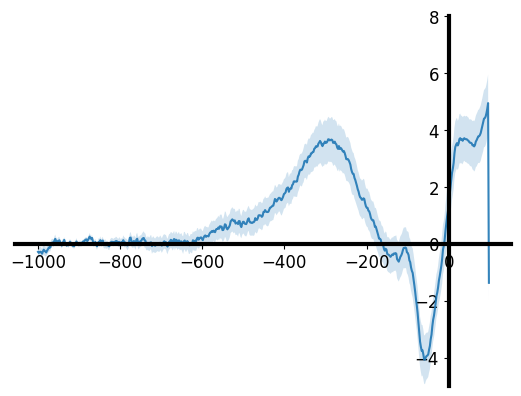

In [7]:
times = np.arange(-1000, 100, 1100/551)
plot_erp_results(data_cpp_across_subject_perc, times, ylim=[-5,8],labelpad=25)

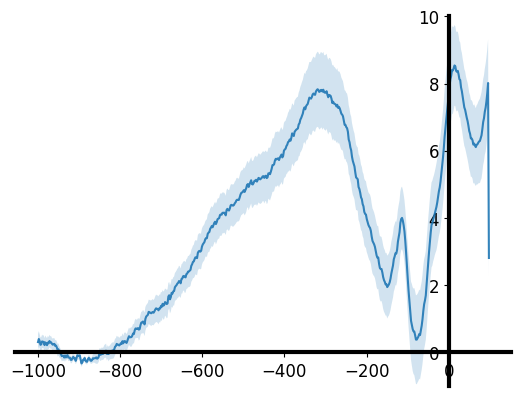

In [8]:
times = np.arange(-1000, 100, 1100/551)
plot_erp_results(data_cpp_across_subject_mem, times, ylim=[-1,10],labelpad=25)